# Trabajo Práctico 2: Análisis con Voting - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [5]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo. También segmentamos el dataset en X e y (target):

In [6]:
df = traer_df()
df = preparar_dataset(df)
X, y = dividir_dataset(df)
X = aplicar_one_hot_encoding(X)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Asignamos los clasificadores a ser utilizados para realizar el ensamble. En este caso, utilizamos los que mejor ROC-AUC score proporcionaron: KNN, SVM y Random Forest, cada uno con sus mejores hiperparámetros.

In [8]:
clf_1 = KNeighborsClassifier(n_neighbors = 60, weights = 'uniform', metric = 'minkowski')
clf_2 = SVC(kernel = 'rbf', gamma = 0.01, C = 1, probability=True)
clf_3 = RandomForestClassifier(max_depth = 17, n_estimators = 500, criterion = 'entropy')

Generamos el ensamble con los modelos anteriormente mencionados:

In [9]:
voting = VotingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], voting='soft', n_jobs = -1
)

## Entrenamiento y predicción con el dataset original

Normalizamos los datos del dataset original y entrenamos el modelo:

In [10]:
X_train, X_test = normalizar_datos(X_train, X_test)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('clf_1', KNeighborsClassifier(n_neighbors=60)),
                             ('clf_2', SVC(C=1, gamma=0.01, probability=True)),
                             ('clf_3',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=17,
                                                     n_estimators=500))],
                 n_jobs=-1, voting='soft')

Ahora hacemos que este prediga sobre el subset de validation:

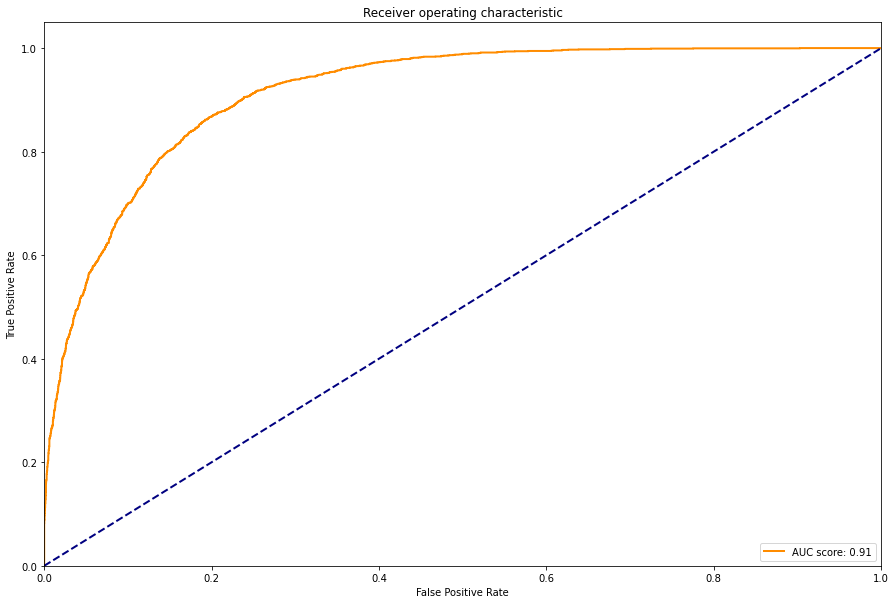

0.9135821189209132

In [11]:
y_pred = voting.predict(X_test)
y_pred_proba = voting.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test, y_pred_proba)

Se puede ver un AUC score muy elevado, que tiene sentido, ya que realizamos una votación entre los modelos con mejor rendimiento.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [12]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.88      0.94      0.91      6159
   Tiene Alto Valor Adquisitivo       0.75      0.58      0.66      1982

                       accuracy                           0.85      8141
                      macro avg       0.81      0.76      0.78      8141
                   weighted avg       0.85      0.85      0.85      8141



Observamos una alta precision y recall para las instancias con bajo valor adquisitivo. Sin embargo, las instancias con alto valor adquisitivo tienen un recall regular, a pesar de tener una alta precision. Esto se ve más claramente en la matriz de confusión, donde se ve que Voting clasifica muy bien a los ceros, y decentemente a los unos.

In [13]:
from funcionesAuxiliares import graficar_matriz_confusion

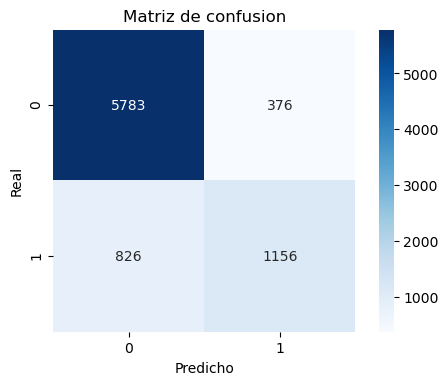

In [14]:
graficar_matriz_confusion(y_test, y_pred)

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [15]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [16]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Generamos el ensamble para el dataset expandido con los modelos anteriormente mencionados:

In [17]:
voting_expandido = VotingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], voting='soft', n_jobs = -1
)

Normalizamos los datos del dataset ampliado y entrenamos el modelo:

In [18]:
X_exp_train, X_exp_test = normalizar_datos(X_exp_train, X_exp_test)
voting_expandido.fit(X_exp_train, y_exp_train)

VotingClassifier(estimators=[('clf_1', KNeighborsClassifier(n_neighbors=60)),
                             ('clf_2', SVC(C=1, gamma=0.01, probability=True)),
                             ('clf_3',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=17,
                                                     n_estimators=500))],
                 n_jobs=-1, voting='soft')

Ahora hacemos que este prediga sobre el subset de validation:

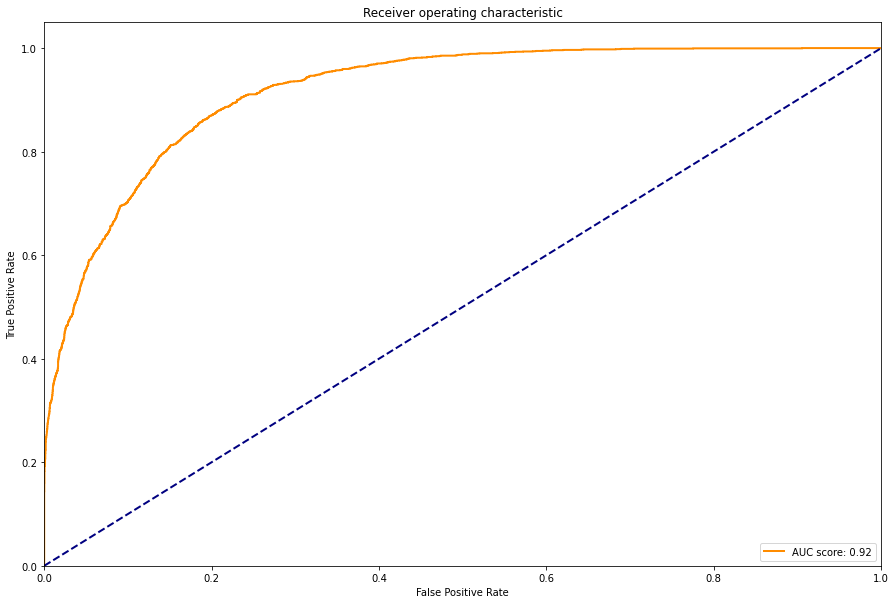

0.9168333314491899

In [19]:
y_pred = voting_expandido.predict(X_exp_test)
y_pred_proba = voting_expandido.predict_proba(X_exp_test)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos observar que el AUC score dio muy alto, incluso levemente mejor al del dataset original. Tiene sentido, ya que estamos haciendo una votación entre varios modelos que tuvieron un score alto.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [20]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.88      0.94      0.91      6159
   Tiene Alto Valor Adquisitivo       0.77      0.60      0.67      1982

                       accuracy                           0.86      8141
                      macro avg       0.82      0.77      0.79      8141
                   weighted avg       0.85      0.86      0.85      8141



Se puede ver una alta precision y recall para las instancias con bajos ingresos. Para los de altos ingresos, se ve una precision relativamente alta, y un recall regular. La predicción se ve más claramente en la siguiente matriz de confusión:

In [21]:
from funcionesAuxiliares import graficar_matriz_confusion

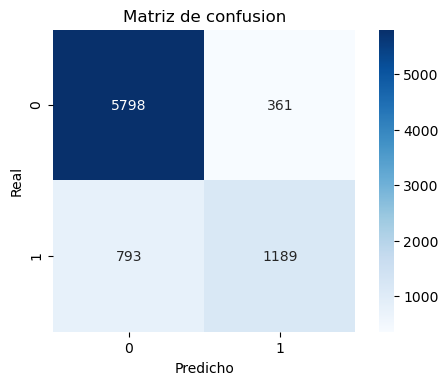

In [22]:
graficar_matriz_confusion(y_test, y_pred)

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con Voting con el dataset ampliado (ya que este tuvo una mejor performance según AUC-ROC) sobre el dataset de holdout, y la escribimos al archivo 'Voting.csv'

In [23]:
from funcionesAuxiliares import traer_holdout
from preprocessing import preparar_holdout
from preprocessing import normalizar_holdout
from funcionesAuxiliares import escribir_predicciones

In [24]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)
holdout_exp = expandir_dataset(holdout)
holdout_exp = aplicar_one_hot_encoding(holdout_exp)
holdout_exp = normalizar_holdout(holdout_exp)

In [25]:
predicciones = voting_expandido.predict(holdout_exp)
escribir_predicciones(ids, predicciones, "Voting")